# Лекция 14. Использование математического сопроцессора

1. Представление чисел с плавающей точкой
2. Регистры математического сопроцессора, команды
3. Действия с числами с плавающей точкой, примеры решения задач

## 1. Представление чисел с плавающей точкой

CPU может работать только с целыми числами. Для работы в вещественными числами используется **FPU (Floating-point unit) или просто математический сопроцессор**. Для правильной работы с вещественными числами их нужно приводить к **нормализованному виду**. В соответствии со стандартом  IEEE 754 вещественное число должно содержать следующий перечень компонент:
- **бит знака** ($S$), который указывает, является ли число положительным или отрицательным;
- **мантисса** ($M$)- это фактически сами цифры числа. Обычно мантисса представляется $0<M<1$;
- **экспонента** ($E$)- это показатель степени, в которую возводится мантисса.

Так числo $3.14$ можно предствавить:

$$0314E+1$$

Здесь $S = 0, M = 0.314, E=10^1$.

В зависимости от разрядности используемых регистров в архитектуре x86-64 поддерживаются различные типы точности представления:

|Размер| Бит знака|Мантисса|Экспонента|
|------|----------|-------------|----------|
|32 бита|1| 23 | 8|
|64 бита|1|52|11|
|80 бит|1|64|15|

В компьютере любые числа конечно представляются в двоичной системе счисления. Вспомним, как эти преобразования выполняются над целой и дробной частью числа.

В качестве примера возьмем число $13.539$. 

Для перевода целой части выполняется деление на основание системы счисления (в нашем случае это 2), полученные остатки от деления, записанные в обратном порядке, и являются результатом перевода:

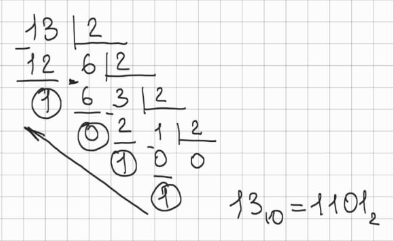

Для перевода дробной части числа она последовательно умножается на основание системы счисления, полученные в результате такого умножения целые части и являются результатом перевода:

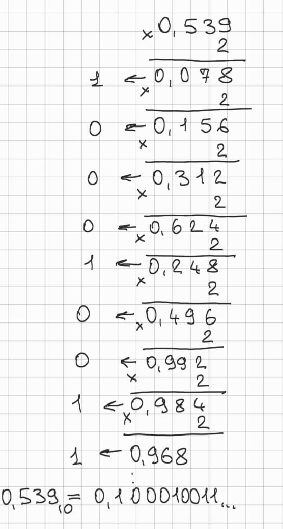

Отсюда видно, что конечная десятичная дробь может быть представлена бесконечной дробью в другой системе счисления.

Таким образом, получаем:

$$1101.100010011_2\ldots \approx 13.539_{10}$$

Для нормализации такого числа в двоичной системе можно всегда подобрать экспоненту, чтобы целая часть была равна единице. Тогда эту единицу можно не хранить и все биты отдать под хранение дробной части:

$$1101.100010011_2 = 1.101100010011_2\cdot (10_2)^3$$

В памяти компьютерна это число будет храниться без цифры целой части:
$$M = 101100010011_2\ldots, E = 11_2$$

Для представления как отрицательных, так и положительных значений степени используется разбиение интервала на две части. 

Например, для размера в 32 бита показатель степени составляет 8 бит и хранится в формате "excess-127". В этом формате экспонента 0 представляет значение 127 (0x7f), отрицательные показатели представляют собой значения в диапазоне от 0 до 126, а положительные показатели — значения в диапазоне от 128 до 255. Таким образом, чтобы получить такое представленние к реальному показатели степени нужно прибавить число 127. Важно также помнить, что числа записываются в памяти в обратном порядке:
- для размера в 32 бита с  0 по 22 биты резервируются для мантиссы ($M$), биты 23-30 предназначены для хранения экспоненты ($E$), сложенной с числом 127. Последний 31-й бит, предназначен для хранения знака числа (1 - знак отрицательный, 0 - положительный).
- для размера в 64 бита с  0 по 51 бит резервируются для хранения мантиссы, биты 52-62 предназначены для хранения экспоненты, сложенной с числом 1023, последний 63-й бит определяет знак числа (1 - знак отрицательный, 0 - положительный);
- для размера в 80 бит с 0 по 63 бит - мантисса числа, биты 64 - 78 – экспонента, сложенная с числом 163835, 79-й, последний бит отводится для знака числа (1 - знак отрицательный, 0 - положительный).

Ниже представлена программа, в которой в разделе .data задано число 13.539 с разной точностью:

db - 1 байт (8 бит);

dw - 2 байта - 1 слово (16 бит)

dd - 4 байта - 2 слова (32 бита)

dq - 8 байт - 4 слова (64 бита)

dt - 10 байт (80 бит)

In [ ]:
;;simple.asm

format elf64
public _start
section '.data' writeable
  
  number_1 dd 13.539
  number_2 dq 13.539
  number_3 dt 13.539

section '.text' executable

_start:
  nop
  mov rax, 60
  syscall

Ниже представлен скриншот дампа памяти исполняемой программы, где записаны эти числа:

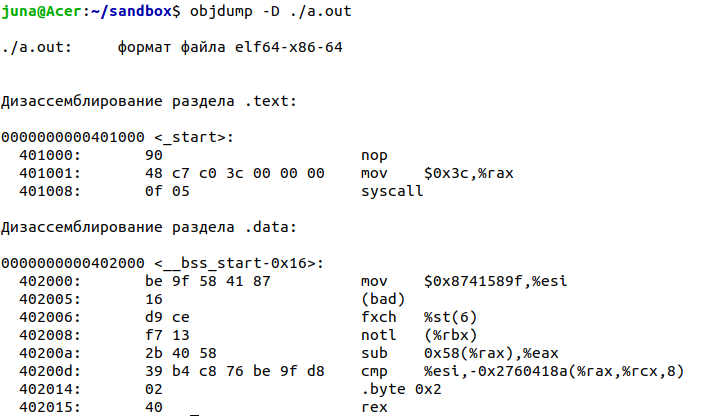

Первые четыре байта хранят представление числа 13.539 в 32-битной точности: 0xbe, 0x9f, 0x58, 0x41.

Их следует записать в обратном порядке: 

In [5]:
print(bin(0x41), bin(0x58), bin(0x9f), bin(0xbe))

0b1000001 0b1011000 0b10011111 0b10111110


Дополним эти числа незначащими нулями до 8 разрядов и выделим три группы байт: S - 1 бит, E - 8 бит, M - 23 бита.

**0 1000001 0 1011000 10011111 10111110**

Видно, что старший бит нулевой - он отвечает за знак плюс (число положительно). 
Под экспоненту выделяется 8 бит: 10000010. 

Для того, чтобы получить экспоненту, нужно из этого числа вычесть 127:

In [32]:
0b10000010 - 127

3

Все оставшиеся биты выделяются под мантиссу, учитывая, что единица целой части не хранится:

10110001001111110111110

Если в полученном у нас представлении: $1.101100010011_2\cdot (10_2)^3\$ отбросить первую цифру целого разряда, то получим совпадение начальных разрядов (мы вычислили дробный разряд менее точно):

In [ ]:
#мантисса в программе: 0b10110001001111110111110

#мантисса у нас:       0b101100010011...........

Аналогичным образом можно выполнить преобразования для 64-битной точности. Для этого берем следующие 8 байт и записываем их в обратном порядке:


In [30]:
print(bin(0x40), bin(0x2b), bin(0x13), bin(0xf7), bin(0xce), bin(0xd9), bin(0x16), bin(0x87))

0b1000000 0b101011 0b10011 0b11110111 0b11001110 0b11011001 0b10110 0b10000111


Дополним эти числа незначащими нулями до 8 разрядов и выделим три группы байт: S - 1 бит, E - 11 бит, M - 52 бита.

**0 10000000010 1011000100111111011111001110110110010001011010000111**

Видно, что знаковый бит нулевой - число положительно.

Под экспоненту отводится 11 бит. Это 0b10000000010

Вычисляем экспоненту:

In [33]:
0b10000000010 - 1023

3

Наконец, получаем мантиссу:

In [34]:
#наше представление: 101100010011...........
#32-битное:          10110001001111110111110
#64-битное:          1011000100111111011111001110110110010001011010000111

Аналогичным образом можно получить число и в 80-битной точности (рекомендуется выполнить это самостоятельно).

Рассмотрим небольшой пример работы с вещественными числами. Поскольку мы не умеем выводить вещественные числа на  экран, используем C. Представление числа с 64-разрядной точностью соответствует типу **double**.

Ниже представлена программа на ассемблере, которая загружает в регистр **xmm0** вещественное число. Напомним, что в соответствии с принятыми соглашениями (Лекция 9) в архитектуре x86-64: если возвращаемое значение является значением с плавающей запятой, оно возвращается через **xmm0**. Если возвращаются два значения, то через регистры **xmm1:xmm0**.

Если функция в качестве параметров принимает числа с плавающей точкой, то они передаются через регистры **xmm0, xmm1, xmm2, xmm3, xmm4, xmm5, xmm6, xmm7**. Если функция принимает значения как с плавающей точкой, так и целые числа, то целые числа передаются обычным способом (с использованием **rdi, rsi, rdx, rcx, r8 и r9**), а числа с плавающей точкой передаются с использованием регистров **XMM**.

Кроме того, для функций (таких как printf или scanf), которые принимают переменное количество аргументов, количество используемых регистров XMM должно быть помещено в rax. 

Функция, реализованная на ассемблере имеет имя **give_number**.

В программе на C объявляется прототип этой функции, тип возвращаемого значения **double**. 

In [ ]:
;;simple_2.asm

format elf64
public give_number
section '.data' writeable
  
  number_2 dq -13.539

section '.text' executable

give_number:
  movq xmm0, [number_2]
  ret

In [ ]:
/*simple.c*/
#include<stdio.h>

double give_number();

int main(){
  
  printf("%f\n",give_number());
  return 0;
}

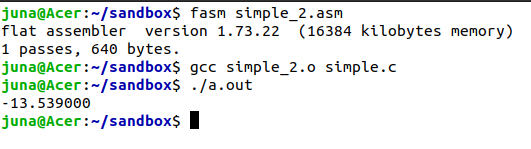

Из скриншота видно, что возвращается заданное вещественное число.

## 2. Регистры математического сопроцессора, команды


FPU просто имеет восемь идентичных 80-битных регистров и три 16-битных регистра (**Control Word**, **Status Word** и **Tag Word**), доступных программисту. Он также имеет внутренний флаговый регистр, который недоступен программисту.

**80-битные регистры**

80-битные регистры образуют стек из восьми регистров. Удобно представлять их как барабан револьвера с 8 отсеками, пронумерованными по часовой стрелке от 0 до 7. Когда FPU инициализируется, все отсеки пусты, а стек находится в состоянии, как показано на рисунке.

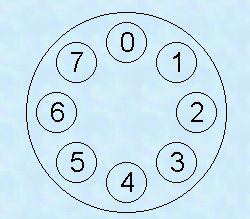

Когда FPU получает команду **ЗАГРУЗИТЬ** значение, он поворачивает барабан по часовой стрелке на один шаг и загружает указанное значение в верхний отсек. Первое значение, загруженное сразу после инициализации FPU, таким образом, попадает в нулевой отсек.

Если бы FPU получил команду загрузить другое значение, он снова повернул бы барабан по часовой стрелке на одну ступень и снова загрузил бы указанное значение в верхний отсек.

Значения можно загружать только в **ВЕРХНИЙ** отсек FPU.

Это может продолжаться до тех пор, пока все отсеки не будут содержать значение. Однако, если попытаться загрузить значение, когда все отсеки имеют значение, барабан все равно повернется на одну метку, но попытка загрузки не удастся (точно так же, как попытка вставить пулю в отсек, который уже содержит пулю). И, кроме того, любое допустимое значение, которое было бы в этом отсеке теперь на СВЕРХУ, также уничтожается, оставляя бесполезный мусор в этом регистре.

Правило: 80-битный регистровый отсек FPU ДОЛЖЕН быть свободным (пустым) для загрузки в него значения.

К счастью, эти регистры можно очистить с помощью различных инструкций FPU. Наиболее распространенный способ обычно называют «выталкиванием регистра». 

Когда FPU получает команду POP значения, он сначала извлекает его из отсека, который в данный момент находится СВЕРХУ, а затем поворачивает барабан против часовой стрелки на один шаг.

Значения можно извлечь только из ВЕРХНЕГО отсека FPU.


Для программиста, при использовании образа вращающегося барабана, 80-битные регистры ВСЕГДА нумеруются по часовой стрелке от 0 до 7, начиная сверха . Часто используют нумерацию  **St(0), St(1), St(2), St(3), St(4), St(5), S(6), St(7)**, но нумерация здесь условна: любое значение, загруженное в FPU, должно изначально называться ST(0), поскольку оно может быть загружено только в верхний отсек. Если FPU будет проинструктировано загрузить другое значение, пока первое все еще там, это второе значение теперь будет называться ST(0), поскольку теперь оно стало значением TOP . Как следствие, первое значение теперь должно называться ST(1). Если загружено другое значение, то первое значение должно называться ST(2). После извлечения последнего загруженного значения это же первое значение снова станет называться ST(1).

Когда регистр выталкивается из FPU, его текущее значение больше не может использоваться ни в одной операции. Если это значение понадобится использовать позже, его следует сохранить в памяти перед выталкиванием и перезагрузить при необходимости. 

### **16-битные регистры**

#### **Control Word**

16-битный регистр **Control Word** используется программистом для выбора между различными режимами вычислений, доступными в FPU, и для определения того, какие исключения должны обрабатываться FPU или обработчиком исключений, написанным программистом.

**Control Word** (**управляющее слово**) разделен на несколько битовых полей, как показано на рисунке:

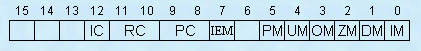

Поле IC (бит 12) или Infinity Control допускает два типа арифметики бесконечности:

- 0 =  -infinity, и +infinity рассматриваются как беззнаковая бесконечность (инициализированное состояние)
- 1 = Учитывает как -infinity, так и +infinity

Это поле было сохранено для совместимости с 287 и более ранними сопроцессорами. В более современных FPU этот бит игнорируется, и учитываются как -infinity, так и +infinity.

Поле RC (биты 11 и 10) или Rounding Control определяет, как FPU будет округлять результаты одним из четырех способов:

- 00 = Округлить до ближайшего или четного, если они равноудалены (это инициализированное состояние)
- 01 = Округлить вниз (в сторону -бесконечности)
- 10 = Округлить вверх (в сторону +бесконечности)
- 11 = Усечение (в сторону 0)

Поле PC (биты 9 и 8) или Precision Control определяет, с какой точностью FPU округляет результаты после каждой арифметической инструкции одним из трех способов:

- 00 = 24 бита (REAL4)
- 01 = Не используется
- 10 = 53 бита (REAL8)
- 11 = 64 бита (REAL10) (это инициализированное состояние)

Поле IEM (бит 7) или Interrupt Enable Mask определяет, будут ли включены какие-либо маски прерываний (бит = 0) или все эти маски будут отключены (бит = 1). Это битовое поле установлено в 1 в инициализированном состоянии. (Это поле также предназначено для совместимости с ранними сопроцессорами и больше не используется.)

Биты 5-0 — это маски прерываний. В инициализированном состоянии все они установлены в 1, что позволяет FPU обрабатывать все исключения. Когда любой из них установлен в 0, он дает команду FPU генерировать прерывание всякий раз, когда обнаруживается это конкретное исключение, чтобы программа выполнила все необходимые действия, прежде чем вернуть управление FPU.

Доступны следующие маски прерываний:

- PM ( бит 5) или Precision Mask 
- UM (бит 4) или Underflow Mask 
- OM ( бит 3 ) или Overflow Mask 
- ZM ( бит 2 ) или Zero delegate Mask 
- DM ( бит 1 ) или Denormalized operand Mask 
- IM (бит 0) или Invalid operation Mask.

Биты 15-13 и 6 зарезервированы или не используются.

#### **Status Word**

16-битный регистр **Status Word** отображает общее состояние FPU. Его содержимое может меняться после завершения каждой инструкции. Часть его не может быть изменена программистом напрямую. Однако к нему можно получить косвенный доступ в любое время для проверки его содержимого.

**Status Word** (**слово статуса**) разделено на несколько битовых полей, как показано на рисунке:

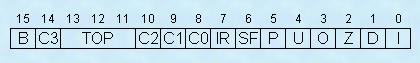

При инициализации FPU все биты сбрасываются в 0.

Поле B (бит 15) указывает, занят ли FPU (B=1) при выполнении инструкции или находится в режиме ожидания (B=0).

Поля C3 (бит 14) и C2 - C0 (биты 10-8) содержат коды условий, следующих за выполнением некоторых инструкций, таких как сравнения.

Поле TOP (биты 13-11) — это то место, где FPU отслеживает, какой из его 80-битных регистров находится в TOP. Номера BC , описанные ранее для внутренней системы нумерации 80-битных регистров FPU, будут отображаться в этом поле. Когда программист указывает один из 80-битных регистров FPU ST(x) в инструкции, FPU добавляет (по модулю 8) номер ST, предоставленный для значения в этом поле TOP , чтобы определить, в каком из его регистров находятся требуемые данные.

Поле IR (бит 7) или запрос прерывания устанавливается в 1 FPU во время обработки исключения и сбрасывается в 0, когда обработка исключения завершена. 

Биты 6-0 — это флаги, которые FPU поднимает всякий раз, когда он обнаруживает исключение. Эти флаги исключений являются кумулятивными в том смысле, что, будучи однажды установленными (бит=1), они не сбрасываются (бит=0) результатом последующей инструкции, которая сама по себе не подняла бы этот флаг. Эти флаги можно сбросить только путем инициализации FPU (инструкция FINIT) или путем явной очистки этих флагов (инструкция FCLEX).

Поле SF (бит 6) или исключение Stack Fault устанавливается всякий раз, когда предпринимается попытка загрузить значение в регистр, который не свободен (бит C1 также будет установлен в 1), или извлечь значение из регистра, который свободен (и бит C1 будет сброшен в 0). 

Поле P (bit5) или исключение точности P устанавливается всякий раз, когда теряется некоторая точность инструкциями, которые выполняют точную арифметику. Например, деление 1 на 10 не дает точного значения в двоичной арифметике и установит флаг исключения P. Другим примером, устанавливающим флаг исключения P, может быть преобразование REAL10 в REAL4, когда некоторые из наименее значимых битов будут потеряны.

Поле U (bit4) или флаг исключения Underflow устанавливается всякий раз, когда значение слишком мало (не равно 0) для правильного представления. Каждый из форматов с плавающей точкой имеет разное ограничение на наименьшее число, которое может быть представлено. Флаг U устанавливается, если результат операции превышает этот предел. Например, деление допустимого очень малого числа на большое число может превысить предел. Допустимое малое число REAL10 может быть намного меньше допустимого для форматов REAL4 или REAL8; в таких случаях преобразование из первого во второй также установит флаг U.
Если FPU обрабатывает это исключение (когда бит UM установлен в управляющем слове), он денормализует значение до тех пор, пока показатель степени не окажется в пределах диапазона или в конечном итоге не вернет 0.

Поле O (bit3) или флаг исключения переполнения O устанавливаются всякий раз, когда значение слишком велико по величине для правильного представления. Опять же, каждый из форматов с плавающей точкой имеет разное ограничение на наибольшее число, которое может быть представлено. Флаг O устанавливается, если результат операции превышает этот предел. Например, умножение допустимого очень большого числа на другое большое число может превысить предел. Допустимое большое число REAL10 может быть намного больше, чем допустимо для форматов REAL4 или REAL8; преобразование из первого во второй также установит флаг O.
Если FPU обрабатывает это исключение (когда бит OM установлен в управляющем слове), он сгенерирует правильно подписанную INFINITY в соответствии с флагом IC управляющего слова.

Поле Z (бит2) или флаг исключения деления на Zero устанавливается всякий раз, когда предпринимается попытка деления конечного ненулевого значения на 0.
Если FPU обрабатывает это исключение (когда бит ZM установлен в управляющем слове), он сгенерирует правильно подписанную INFINITY в соответствии с XOR знаков операндов, а затем в соответствии с флагом IC управляющего слова.

Поле D (бит1) или флаг исключения Denormalized устанавливается всякий раз, когда инструкция пытается работать с денормализованным числом или результатом операции является денормализованное число.
Если FPU обрабатывает это исключение (когда бит DM установлен в управляющем слове), он просто продолжит обычную обработку, а затем проверит другие возможные исключения.

Поле I (bit0) или флаг исключения операции Invalid устанавливается всякий раз, когда операция считается недействительной FPU. Примерами таких операций являются:
- Переполнение или потеря значимости стека
- Неопределенная арифметика, например, деление 0 на 0 или вычитание бесконечности из бесконечности
- Использование Not-A-Number (NAN) в качестве операнда с некоторыми инструкциями
- Попытка извлечь квадратный корень из отрицательного числа

Если FPU обрабатывает это исключение (когда бит IM установлен в управляющем слове), он либо возвращает NAN, если один из них используется в качестве операнда (или большее абсолютное значение, если в качестве операндов используются два NAN), либо в противном случае возвращает специальный «INDEFINITE» NAN.

#### **Tag Word**

16-битный регистр **Tag Word** (**теговое слово**) управляется FPU для хранения некоторой информации о содержимом каждого из его 80-битных регистров.

Слово тега разделено на 8 полей по 2 бита каждое, как показано на рисунке:

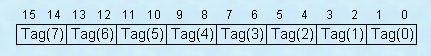

Вышеуказанные номера тегов соответствуют внутренней системе нумерации FPU для 80-битных регистров. Значение каждой пары бит следующее:

- 00 = Регистр содержит допустимое ненулевое значение
- 01 = Регистр содержит значение, равное 0
- 10 = Регистр содержит специальное значение (NAN, бесконечность или ненормальное)
- 11 = Регистр пуст

При инициализации FPU все 80-битные регистры пусты, и, таким образом, слово тега будет иметь общее значение
1111111111111111b (FFFFh).

Если затем загружено допустимое ненулевое значение, то теговое слово изменится на
0011111111111111b (3FFFh).

Если затем загрузить второе значение, равное 0, то теговое слово станет
0001111111111111b (1FFFh).

Хотя это Tag Word может содержать информацию, которая также может быть полезна программисту, к нему нельзя получить доступ напрямую.

## Команды FPU

Рассмотрим некоторые команды FPU. Более подробно можно посмотреть по [ссылке](https://linasm.sourceforge.net/docs/instructions/fpu.php)

### Инициализация

|Команда | Действие|
|-----|--------|
|FFREE ST(i)|Устанавливает тег в регистре тега FPU, связанном с регистром ST(i), на пустой|
|FINIT|Устанавливает регистры управления FPU, статуса, тега, указателя инструкций и указателя данных в их состояния по умолчанию.|


### Математические константы

Команды ниже загружают в вершину стека St(0) соответствующую математическую константу

|Команда | Действие|
|-----|--------|
|FLDZ|Загрузка +0.0|
|FLD1 |Загрузка +1.0|
|FLDPI|Загрузка Pi|
|FLDL2E|Загрузка log2(e)|
|FLDLN2|Загрузка loge(2)|
|FLDL2T|Загрузка log2(10)|
|FLDLG2|Загрузка log10(2)|

### Перемещение данных
|Команда | Действие|
|-----|--------|
| FILD m64int |Преобразует знаковый целый операнд источника в формат с плавающей точкой двойной расширенной точности и помещает значение в стек регистров FPU. Операнд источника может быть целым числом размером word, doubleword или quadword. Он загружается без ошибок округления. Знак операнда источника сохраняется.|
|FIST m64int, FISTP m64int|Инструкция FIST преобразует значение в регистре ST(0) в знаковое целое число и сохраняет результат в операнде назначения. Значения могут быть сохранены в формате целого слова или двойного слова. Операнд назначения указывает адрес, по которому должен быть сохранен первый байт значения назначения. Инструкция FISTP выполняет ту же операцию, что и инструкция FIST, а затем выталкивает стек регистров. Чтобы вытолкнуть стек регистров, процессор отмечает регистр ST(0) как пустой и увеличивает указатель стека (TOP) на 1|
|FLD m32fp, FLD m64fp, FLD m80fp, FLD St(i)|Помещает исходный операнд в стек регистров FPU. Исходный операнд может быть в формате с плавающей точкой одинарной точности, двойной точности или двойной расширенной точности. Если исходный операнд находится в формате с плавающей точкой одинарной точности или двойной точности, он автоматически преобразуется в формат с плавающей точкой двойной расширенной точности перед помещением в стек. Инструкция FLD также может помещать значение в выбранный регистр FPU [ST(i)] в стек. Здесь помещение в стек регистра ST(0) дублирует вершину стека.|
|FST m32(64, 80)fp, FSTP m32(64, 80)fp, FST ST(i), FSTP ST(i)|Инструкция FST копирует значение из регистра ST(0) в целевой операнд, который может быть ячейкой памяти или другим регистром в стеке регистров FPU. При сохранении значения в памяти оно преобразуется в формат с плавающей точкой одинарной или двойной точности. Инструкция FSTP выполняет ту же операцию, что и инструкция FST, а затем выталкивает стек регистров. Чтобы вытолкнуть стек регистров, процессор отмечает регистр ST(0) как пустой и увеличивает указатель стека (TOP) на 1. Инструкция FSTP также может хранить значения в памяти в формате с плавающей точкой двойной расширенной точности.|
|FXCH ST(i)|Поменять местами содержимое ST(0) и ST(i).|



### Математические функции

|Команда|Действие|
|-------|--------|
|FSIN |Вычисляет приближение синуса исходного операнда в регистре ST(0) и сохраняет результат в ST(0) |
|FCOS|Вычисляет приблизительный косинус исходного операнда в регистре ST(0) и сохраняет результат в ST(0)|
|F2XM1|$2^x − 1$|

### Арифметические операции

**Операции с целыми числами**

|Команда|Действие|
|-----|-----------|
|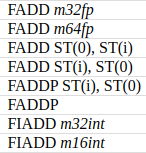|Складывает операнды назначения и источника и сохраняет сумму в месте назначения. Операнд назначения всегда является регистром FPU; операнд источника может быть регистром или местом памяти. Операнды источника в памяти могут быть в формате с плавающей точкой одинарной или двойной точности или в формате целого слова или двойного слова.|
|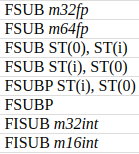|Вычитает исходный операнд из целевого операнда и сохраняет разницу в целевом месте. Целевой операнд всегда является регистром данных FPU; исходный операнд может быть регистром или местом в памяти. Исходные операнды в памяти могут быть в формате с плавающей точкой одинарной или двойной точности или в формате целого слова или двойного слова.|
|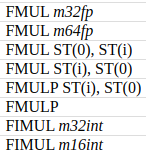|Умножает операнды назначения и источника и сохраняет результат в месте назначения. Операнд назначения всегда является регистром данных FPU; операнд источника может быть регистром данных FPU или местом памяти. Операнды источника в памяти могут быть в формате с плавающей точкой одинарной или двойной точности или в формате целого слова или двойного слова.|
|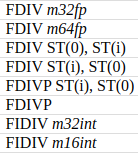|Делит операнд назначения на операнд источника и сохраняет результат в месте назначения. Операнд назначения (делимое) всегда находится в регистре FPU; операнд источника (делитель) может быть регистром или местом в памяти. Операнды источника в памяти могут быть в формате с плавающей точкой одинарной или двойной точности, в формате целого слова или двойного слова.|

**Операции с вещественными числами**

|Команда|Действие|
|-----|-----------|
|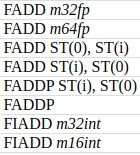|Складывает операнды назначения и источника и сохраняет сумму в месте назначения. Операнд назначения всегда является регистром FPU; операнд источника может быть регистром или местом памяти. Операнды источника в памяти могут быть в формате с плавающей точкой одинарной или двойной точности или в формате целого слова или двойного слова.|
|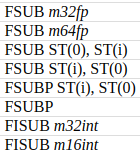|Вычитает исходный операнд из целевого операнда и сохраняет разницу в целевом месте. Целевой операнд всегда является регистром данных FPU; исходный операнд может быть регистром или местом в памяти. Исходные операнды в памяти могут быть в формате с плавающей точкой одинарной или двойной точности или в формате целого слова или двойного слова.|
|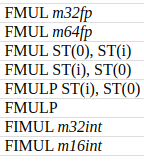|Умножает операнды назначения и источника и сохраняет результат в месте назначения. Операнд назначения всегда является регистром данных FPU; операнд источника может быть регистром данных FPU или местом памяти. Операнды источника в памяти могут быть в формате с плавающей точкой одинарной или двойной точности или в формате целого слова или двойного слова.|
|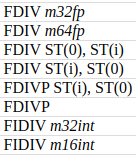|Делит операнд назначения на операнд источника и сохраняет результат в месте назначения. Операнд назначения (делимое) всегда находится в регистре FPU; операнд источника (делитель) может быть регистром или местом в памяти. Операнды источника в памяти могут быть в формате с плавающей точкой одинарной или двойной точности, в формате целого слова или двойного слова.|
|FPREM|Вычисляет остаток, полученный от деления значения в регистре ST(0) (делимое) на значение в регистре ST(1) (делитель или модуль ), и сохраняет результат в ST(0). |
|FRNDINT|Округляет исходное значение в регистре ST(0) до ближайшего целого значения в зависимости от текущего режима округления (настройки поля RC управляющего слова FPU) и сохраняет результат в ST(0).|
|FABS|Очищает бит знака ST(0) для создания абсолютного значения операнда.|
|FCHS|Дополняет знаковый бит ST(0). Эта операция изменяет положительное значение на отрицательное значение равной величины или наоборот.|
|FSQRT|Вычисляет квадратный корень исходного значения в регистре ST(0) и сохраняет результат в ST(0).|


## 3. Действия с числами с плавающей точкой, примеры решения задач

Рассмотрим ряд примеров на использование математического сопроцессора в программах.

**Пример 1.** Программа выводит заданное вещественное число на экран, используя функцию printf языка C. 

In [ ]:
;;out_float.asm

format elf64
public _start

extrn printf

section '.data' writeable
 
 number dq -13.124
 prt db "%f", 0xa, 0

section '.text' executable

_start:
  mov rdi, prt ;Строка вывода для printf
  movq xmm0, [number] ;вещественные числа загружаем в регистры xmm
  mov rax, 1 ;в rax нужно указать, сколько используется регистров xmm для передачи в printf 
  call printf
  
  mov rax, 60
  mov rdi, 0
  syscall

Поскольку используем функции языка C, линкуем с использованием динамического компоновщика.

> fasm out_float.asm

> ld out_float.o -lc -dynamic-linker /lib64/ld-linux-x86-64.so.2 -o out_float

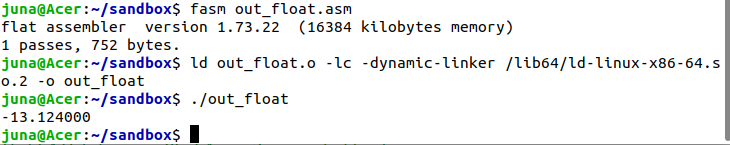

**Пример 2.** Программа загружает из математического сопроцессора константу $\pi$ и выводит ее на экран.

In [ ]:
;;pi.asm

format elf64
public _start

extrn printf

section '.data' writeable

 output db "%f", 0xa, 0
 
section '.bss' writeable

  pi rq 1

section '.text' executable

_start:
  
  FINIT  ;;инициализируем мат. сопроцессор
  FLDPI  ;;загружаем pi в st0
  FSTP [pi] ;;выгружаем значение в ячейку памяти
  
  movq xmm0, [pi]
  mov rax, 1
  mov rdi, output
  call printf
  
  mov rax, 60
  mov rdi, 0
  syscall

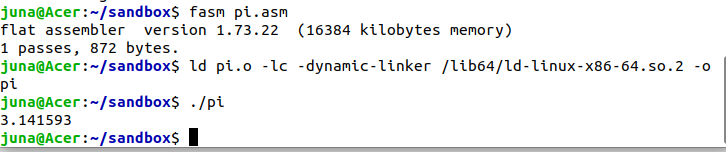

**Пример 3.** В программе вводится вещественное число, с использованием математического сопроцесора вычисляется и выводится квадратный корень из этого числа.

Ниже представлена программа на C, в которой используется соответствующая функция, написанная на ассемблере.

In [ ]:
/* sqrt.c */
#include<stdio.h>

double sqrt(double);

int main(){
  double x;
  scanf("%lf",&x);
  printf("%f\n", sqrt(x));
  return 0;
}

Сама программа на языке ассемблере выглядит следующим образом:

In [ ]:
;;sqrt.asm

format elf64
public sqrt

section '.bss' writeable

  input_number rq 1

section '.text' executable

sqrt:
  
  movq [input_number], xmm0 ;Сохраняем значение входного параметра в памяти
  ffree st0                 ;Помечаем вершину стека свободной
  fld [input_number]        ;загружаем в вершину стека входное значение
  fsqrt                     ;извлекаем квадратный корень
  fstp [input_number]       ;сохраняем полученое значение с вершины стека в памяти
  
  movq xmm0, [input_number] ;загружаем регистр xmm0 для возврата значения
  mov rax, 1                ;указываем количество исползуемых параметров xmm
  ret 

Реализуем также данную программу на чистом ассемблере. Для разнообразия подключим еще математическую библиотеку C math и сравним результаты.

In [ ]:
;;sqrt_2.asm

format elf64
public _start

extrn scanf
extrn printf
extrn sqrt

section '.data' writable

  input db "%lf",0 
  output db "%f", 0xa, 0

section '.bss' writable

  number rq 1
  number_2 rq 1
  
section '.text' executable

_start:
  
  mov rdi, input
  mov rsi, number
  movq xmm0, rsi
  mov rax, 1
  call scanf
  
  movq [number], xmm0 
  movq [number_2], xmm0
  ffree st0 
  fld [number] 
  fsqrt
  fstp [number] 
  
  movq xmm0, [number] 
  mov rax, 1  
  mov rdi, output
  call printf
  
  ;;Используем математическую библиотеку для сравнения
  movq xmm0, [number_2]
  mov rax, 1
  call sqrt
  
  mov rax, 1  
  mov rdi, output
  call printf
  
  mov rax, 60
  mov rdi, 0
  syscall

> fasm sqrt_2.asm

> ld sqrt_2.o -lc -lm -dynamic-linker /lib64/ld-linux-x86-64.so.2 -o sqrt_2

Линкуем с подключением мат. библиотеки: ключ -lm.

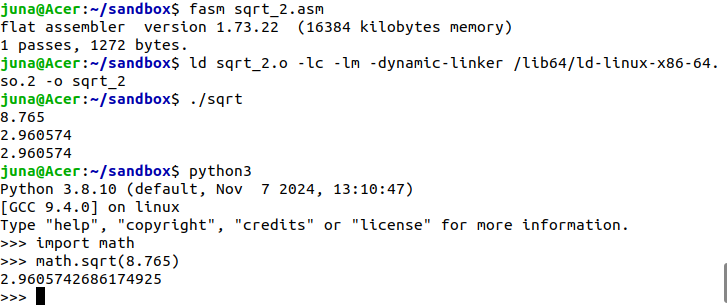

Наконец, в следующей программе, используя функцию **atof** из библиотеки **stdlib.h**, число, из которого нужно извлечь квадратный корень берется непосредственно с командной строки. 

In [ ]:
;;sqrt_3.asm

format elf64
public _start

extrn printf
extrn atof


section '.data' writable

  output db "%f", 0xa, 0

section '.bss' writable

  number rq 1
  buffer rb 100

  
section '.text' executable

_start:
  mov rdi, [rsp + 16]
  mov rax, 0
  call atof
  
  movq [number], xmm0 
  ffree st0 
  fld [number] 
  fsqrt
  fstp [number] 
  
  movq xmm0, [number] 
  mov rax, 1  
  mov rdi, output
  call printf
  
  mov rax, 60
  mov rdi, 0
  syscall

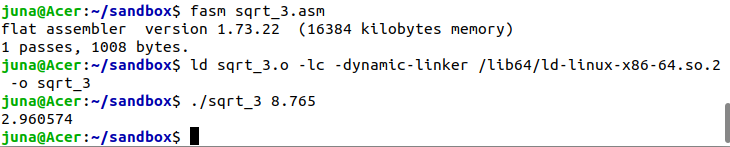

**Пример 4.** Выполнить сложение, умножение, вычитание, деление двух вещественных чисел. Числа взять как параметры командной строки.

In [ ]:
;;add_sub.asm

format elf64
public _start

extrn printf
extrn atof

section '.data' writable

  sum db "%f + %f = %f", 0xa, 0
  difference db "%f - %f = %f", 0xa, 0
  prod db "%f * %f = %f", 0xa, 0
  division db "%f / %f = %f", 0xa, 0

section '.bss' writable

  operator_1 rq 1
  operator_2 rq 1
  
  result rq 1
  
section '.text' executable

_start:

  ;;Читаем параметры командной строки, преобразуем из в вещественные числа, сохраняем в памяти
  mov rdi, [rsp + 16]
  mov rax, 0
  call atof
  movq [operator_1], xmm0 
  
  mov rdi, [rsp + 24]
  mov rax, 0
  call atof
  movq [operator_2], xmm0 
  
  ;;Загружаем данные в стековые регистры, выполняем сложение
  ffree st0 
  ffree st1
  fld [operator_1] 
  fld [operator_2]
  fadd st0, st1
  fstp [result]
  
  ;;Выводим результат суммы
  movq xmm0, [operator_1] 
  movq xmm1, [operator_2]
  movq xmm2, [result]
  mov rax, 3  
  mov rdi, sum
  call printf
  
  ;;Загружаем данные в стековые регистры, выполняем умножение
  ffree st0 
  ffree st1
  fld [operator_1] 
  fld [operator_2]
  fmul st0, st1
  fstp [result]
  
  ;;Выводим результат умножения
  movq xmm0, [operator_1] 
  movq xmm1, [operator_2]
  movq xmm2, [result]
  mov rax, 3  
  mov rdi, prod
  call printf
  
  ;;Загружаем данные в стековые регистры, выполняем вычитание
  ffree st0 
  ffree st1
  fld [operator_2] 
  fld [operator_1]
  fsub st0, st1
  fstp [result]
  
  ;;Выводим результат вычитания
  movq xmm0, [operator_1] 
  movq xmm1, [operator_2]
  movq xmm2, [result]
  mov rax, 3  
  mov rdi, difference
  call printf
  
  ;;Загружаем данные в стековые регистры, выполняем деление
  ffree st0 
  ffree st1
  fld [operator_2] 
  fld [operator_1]
  fdiv st0, st1
  fstp [result]
  
  ;;Выводим результат деления
  movq xmm0, [operator_1] 
  movq xmm1, [operator_2]
  movq xmm2, [result]
  mov rax, 3  
  mov rdi, division
  call printf
  
  mov rax, 60
  mov rdi, 0
  syscall

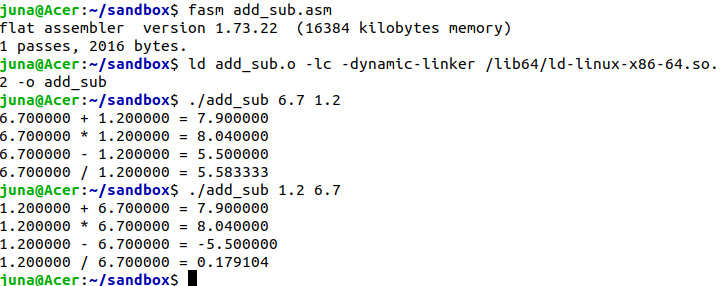

В программе следует обратить внимание на порядок загрузки стековых регистров при вычитании и делении. Поскольку эти операции несимметричны, сначала в стек помещают второй операнд, барабан поворачивается, и затем в стек помещают первый операнд. Это обеспечивает правильный порядок - первый операнд делится на второй операнд (из него вычитается второй операнд).